# PCA

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pathlib import Path
import sys
sys.path.append('../../')
from utils.metrics import calculate_anomaly_metrics, format_results

In [15]:
# 1. CARGAR DATOS
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

# 2. FEATURES
feature_cols = [
    'sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21'
]


In [16]:
def get_baseline(df, pct=0.3):
    baseline_list = []
    for unit in df['unit_id'].unique():
        unit_data = df[df['unit_id'] == unit]
        cutoff = unit_data['time_cycles'].max() * pct
        baseline_list.append(unit_data[unit_data['time_cycles'] <= cutoff])
    return pd.concat(baseline_list)

baseline = get_baseline(train)
X_baseline = baseline[feature_cols].values

# 4. ENTRENAR PCA EN BASELINE
scaler = StandardScaler()
X_baseline_scaled = scaler.fit_transform(X_baseline)

# Usar componentes que expliquen 95% varianza
pca = PCA(n_components=0.95)
pca.fit(X_baseline_scaled)

,n_components,0.95
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


In [17]:
print(f"Componentes seleccionados: {pca.n_components_}")
print(f"Varianza explicada: {pca.explained_variance_ratio_.sum():.2%}")

# 5. CALCULAR ERROR DE RECONSTRUCCIÓN EN BASELINE
X_baseline_pca = pca.transform(X_baseline_scaled)
X_baseline_reconstructed = pca.inverse_transform(X_baseline_pca)
baseline_errors = np.mean((X_baseline_scaled - X_baseline_reconstructed)**2, axis=1)

# 6. DEFINIR UMBRAL (percentil 99 del baseline)
threshold = np.percentile(baseline_errors, 99)
print(f"\nUmbral (p99): {threshold:.4f}")

Componentes seleccionados: 2
Varianza explicada: 99.12%

Umbral (p99): 0.0435


In [18]:
# 7. DETECTAR ANOMALÍAS EN TRAIN
X_train = train[feature_cols].values
X_train_scaled = scaler.transform(X_train)
X_train_pca = pca.transform(X_train_scaled)
X_train_reconstructed = pca.inverse_transform(X_train_pca)

# Error de reconstrucción
train['reconstruction_error'] = np.mean((X_train_scaled - X_train_reconstructed)**2, axis=1)
train['is_anomaly'] = (train['reconstruction_error'] > threshold).astype(int)

# 8. MÉTRICAS
metrics = calculate_anomaly_metrics(train)
metrics['method'] = 'PCA'
metrics['dataset'] = 'FD001'
format_results(metrics)

📊 PCA - FD001
Cobertura: 85.9% (214/249 unidades)
RUL promedio 1ª detección: 74.4 ciclos
Detección al 66.5% del ciclo
Detecciones tempranas (RUL>50): 90
Falsos positivos (RUL>150): 20.1%
% anomalías totales: 2.7%


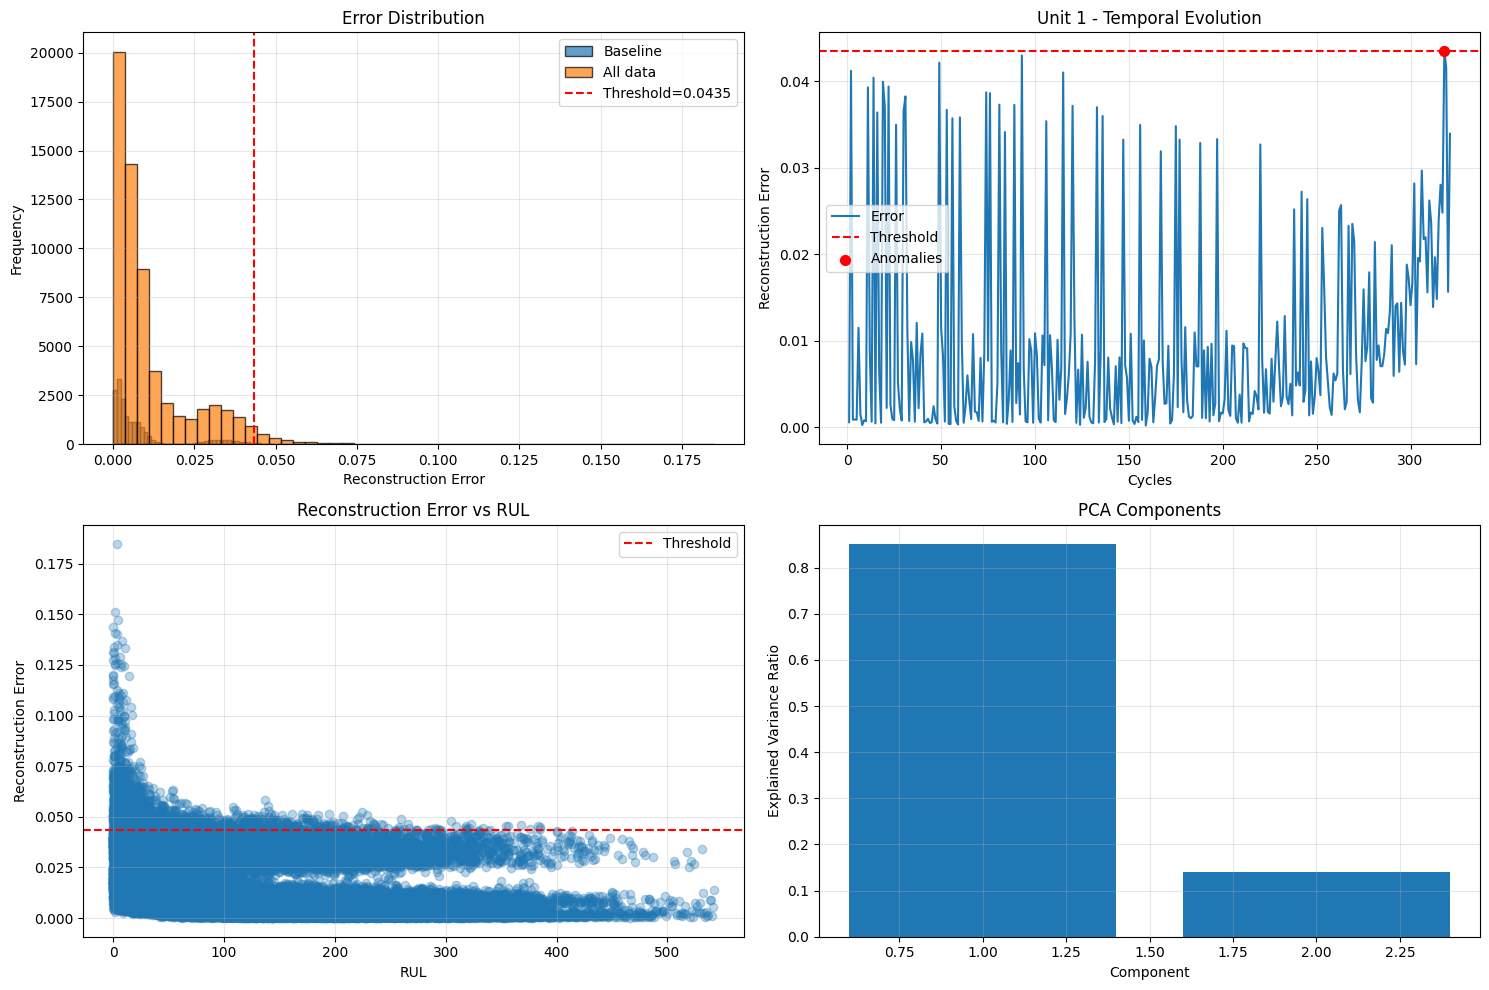


✅ Resultados guardados en ./outputs/


In [19]:
# 9. VISUALIZACIÓN
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# a) Distribución de errores
axes[0, 0].hist(baseline_errors, bins=50, alpha=0.7, label='Baseline', edgecolor='black')
axes[0, 0].hist(train['reconstruction_error'], bins=50, alpha=0.7, label='All data', edgecolor='black')
axes[0, 0].axvline(threshold, color='r', linestyle='--', label=f'Threshold={threshold:.4f}')
axes[0, 0].set_xlabel('Reconstruction Error')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Error Distribution')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# b) Evolución temporal ejemplo (unidad 1)
unit_1 = train[train['unit_id'] == 1]
axes[0, 1].plot(unit_1['time_cycles'], unit_1['reconstruction_error'], label='Error')
axes[0, 1].axhline(threshold, color='r', linestyle='--', label='Threshold')
axes[0, 1].scatter(unit_1[unit_1['is_anomaly']==1]['time_cycles'], 
                   unit_1[unit_1['is_anomaly']==1]['reconstruction_error'], 
                   color='red', s=50, label='Anomalies', zorder=3)
axes[0, 1].set_xlabel('Cycles')
axes[0, 1].set_ylabel('Reconstruction Error')
axes[0, 1].set_title('Unit 1 - Temporal Evolution')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# c) Error vs RUL
axes[1, 0].scatter(train['RUL'], train['reconstruction_error'], alpha=0.3)
axes[1, 0].axhline(threshold, color='r', linestyle='--', label='Threshold')
axes[1, 0].set_xlabel('RUL')
axes[1, 0].set_ylabel('Reconstruction Error')
axes[1, 0].set_title('Reconstruction Error vs RUL')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# d) Componentes principales
axes[1, 1].bar(range(1, len(pca.explained_variance_ratio_)+1), 
               pca.explained_variance_ratio_)
axes[1, 1].set_xlabel('Component')
axes[1, 1].set_ylabel('Explained Variance Ratio')
axes[1, 1].set_title('PCA Components')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('./outputs/pca_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# 10. GUARDAR RESULTADOS
output_dir = Path('./outputs')
output_dir.mkdir(exist_ok=True)

train[['unit_id', 'time_cycles', 'RUL', 'reconstruction_error', 'is_anomaly']].to_csv(
    output_dir / 'pca_anomalies.csv', index=False
)

pd.DataFrame([metrics]).to_csv(
    output_dir / 'pca_metrics.csv', index=False
)

print("\n✅ Resultados guardados en ./outputs/")

In [20]:
# Verifica métricas globales
metrics = calculate_anomaly_metrics(train)
print(f"RUL promedio 1ª detección: {metrics['avg_first_detection_rul']:.1f}")
print(f"Cobertura: {metrics['detection_rate']:.1f}%")
print(f"Falsos positivos (RUL>150): {metrics['false_positive_rate']:.1f}%")

RUL promedio 1ª detección: 74.4
Cobertura: 85.9%
Falsos positivos (RUL>150): 20.1%
